In [ ]:
import torch
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cnn_model = torchvision.models.mobilenet_v3_small(pretrained=True, download=True, progress = False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [ ]:
# !rm -rf ./data/imagenette2-320/

In [ ]:
from torchvision.datasets import Imagenette
composed_transforms =transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
data = Imagenette('./data', split = "train", size = "320px", download = True, transform=composed_transforms)

100%|██████████| 341663724/341663724 [00:26<00:00, 12923554.63it/s]


Extracting ./data/imagenette2-320.tgz to ./data


In [ ]:
train_data = torchvision.datasets.ImageFolder('/content/data/imagenette2-320/train', transform=composed_transforms)
test_data = torchvision.datasets.ImageFolder('/content/data/imagenette2-320/val', transform=composed_transforms)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_dl = DataLoader(train_data, shuffle = True, batch_size = 30)
test_dl = DataLoader(test_data, shuffle = True, batch_size = 30)

In [ ]:
x, y = next(iter(train_dl))

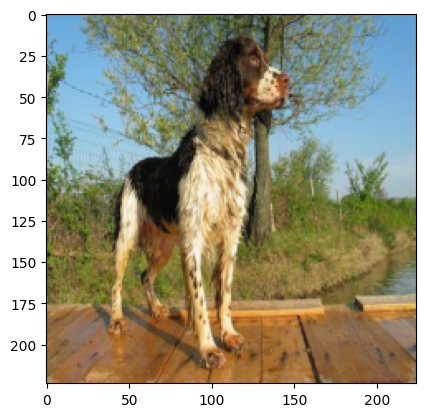

In [ ]:
plt.imshow(x[0].permute(1,2,0))

In [ ]:
device = torch.device("cuda:0")

In [ ]:
# cnn_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
num_features = cnn_model.classifier[-1].in_features
cnn_model.classifier[-1] = nn.Linear(num_features, len(data.classes))

In [ ]:
model_optim = torch.optim.Adam(cnn_model.parameters(), lr = 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/AI explanability/"

In [ ]:
def save_checkpoint(model, path, name, epoch):
      torch.save({
            "epoch":epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':model_optim.state_dict()
      }, f'{path}{name}-latest.pkl')
      print('Saved Checkpoints !')


def load_checkpoints(model, path, name):
      checkpoint = torch.load(f'{path}{name}-latest.pkl')
      model.load_state_dict(checkpoint['model_state_dict'])
      model_optim.load_state_dict(checkpoint['optimizer_state_dict'])

      print('Loaded Checkpoints !')

In [ ]:
def train(model, name, path, save=False):
    epochs = 10
    model.to(device)
    train_loss_history = []
    validation_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        for data, labels in tqdm(train_dl):
            model_optim.zero_grad()
            data = data.to(device)
            labels = labels.to(device)
            preds = model(data)

            loss = loss_fn(preds, labels)
            loss.backward()
            model_optim.step()
        print(f'Epoch : {epoch} | Loss : {loss.detach().item()}')
        train_loss_history.append(loss.detach().item())
        val_loss, val_acc = test(model)
        validation_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
    if save:
        save_checkpoint(model, path, name, epochs)
    return train_loss_history, validation_loss_history, val_acc_history


def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for data, labels in tqdm(test_dl):
            data = data.to(device)
            labels = labels.to(device)
            preds = model(data)

            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Accuracy : {correct/total * 100}")
        return loss_fn(preds, labels).detach().item(), correct/total


In [ ]:
# train_loss, val_loss, val_acc = train(cnn_model, "ea-latest-imagenette", save_path, True)

In [ ]:
load_checkpoints(cnn_model, save_path, "ea-latest-imagenette")

Loaded Checkpoints !


In [ ]:
def predict_label(image, logits = False):
    cnn_model.to(device)
    cnn_model.eval()
    image = image.reshape(1, 3, 224, 224).to(device)
    predicted_label = torch.argmax(cnn_model(image)[0])
    if logits:
        return cnn_model(image)[0]
    return predicted_label.item()

In [ ]:
def predict_batch(images):
    images = images.to(device)
    cnn_model.to(device)
    cnn_model.eval()
    pred = cnn_model(images)
    _, predicted = torch.max(pred.data, 1)
    return predicted

In [ ]:
def predict_intermediate(image, k):
  cnn_model.to(device)
  cnn_model.eval()
  image = image.reshape((1, 3, 224, 224)).float().to(device)
  output = cnn_model.features[0](image)

  for i in range(1,k):
    output = cnn_model.features[i](output)

  # output = cnn_model.features[3](output)
  return output

In [ ]:
predict_label(x[0])

1

In [ ]:
predict_batch(x)

tensor([1, 4, 5, 0, 8, 0, 9, 6, 0, 7, 3, 4, 5, 0, 8, 8, 4, 0, 0, 7, 0, 0, 4, 9,
        4, 8, 7, 8, 7, 7], device='cuda:0')

Text(0.5, 1.0, "Actual :('garbage truck', 'dustcart'), Predicted :('garbage truck', 'dustcart')")

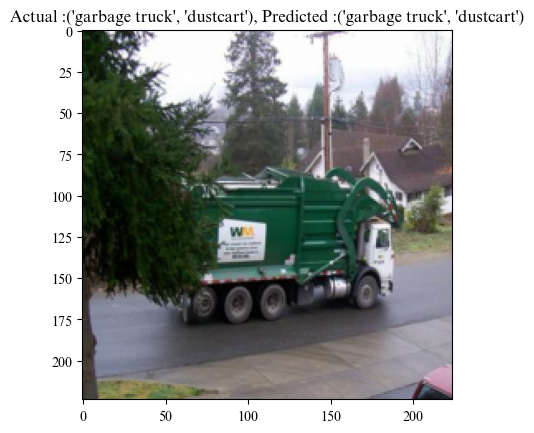

In [ ]:
k = 10
plt.imshow(x[k].permute(1, 2, 0))
plt.title(f'Actual :{data.classes[y[k].item()]}, Predicted :{data.classes[predict_label(x[k])]}')

In [ ]:
zero_mask = np.zeros((224, 224))
print(f"Shape of the zero mask is : {zero_mask.shape}")

Shape of the zero mask is : (224, 224)


In [ ]:
coordinates = [i for i in range(224)]
radius = [8, 11, 5]
def create_random_coordinates_and_radius():
    x = np.random.choice(coordinates)
    y = np.random.choice(coordinates)
    r = np.random.choice(radius)
    return [x, y, r]

def create_batch_coordinates(batch_size=50):
    return [create_random_coordinates_and_radius() for _ in range(batch_size)]

def get_bounding_box_index(coordinate, radius):

    minx = coordinate[0]-radius
    maxx = coordinate[0]+radius+1

    miny = coordinate[1]-radius
    maxy = coordinate[1]+radius+1

    x0 = min(coordinate[0], abs(minx))
    x1 = min(zero_mask.shape[0], abs(maxx))


    y0 = min(coordinate[1], abs(miny))
    y1 = min(zero_mask.shape[1], abs(maxy))

    return x0, y0, x1, y1

def create_hole_in_mask(coordinate_batch):
    individual = zero_mask.copy()
    for coordinates in coordinate_batch:
        x0, y0, x1, y1 = get_bounding_box_index(coordinates[:2], coordinates[2])
        individual[x0:x1:1, y0:y1:1]=1
    return individual

def generate_population(size = 40):
    population = []
    coordinate_batch = []
    for i in range(size):
        batch_coordinates = create_batch_coordinates()
        coordinate_batch.append(batch_coordinates)
        individual = create_hole_in_mask(batch_coordinates)
        population.append(individual)
    return population,coordinate_batch



In [ ]:
def create_random_coordinates_and_radius_crops():
    x = np.random.choice(coordinates)
    y = np.random.choice(coordinates)
    r = np.random.choice([30,35,40])
    return [x, y, r]

def create_batch_coordinates_crops(batch_size=60):
    return [create_random_coordinates_and_radius_crops() for _ in range(batch_size)]

def generate_crops(size = 40):
    population = []
    coordinate_batch = []
    for i in range(size):
        batch_coordinates = create_batch_coordinates_crops(4)
        coordinate_batch.append(batch_coordinates)
        individual = create_hole_in_mask(batch_coordinates)
        population.append(individual)
    return population,coordinate_batch

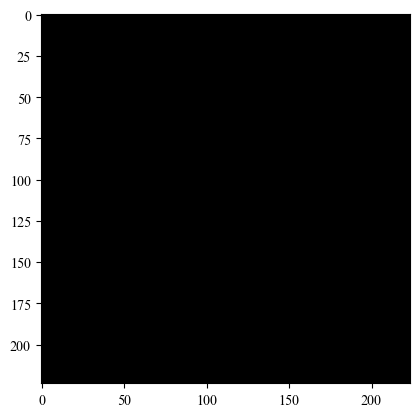

In [ ]:
plt.imshow(zero_mask, cmap = 'gray')

In [ ]:
temp_population, temp_coordinates = generate_crops()

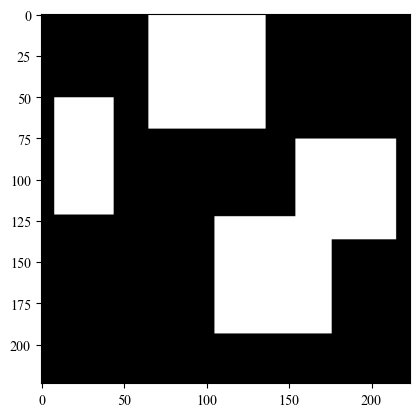

In [ ]:
plt.imshow(temp_population[0], cmap="gray")

In [ ]:
def apply_mask(image, mask):
    mask = torch.tensor(mask).reshape(224,224)
    mask_expand = torch.stack([mask for _ in range(3)])
    return image.mul(mask)

In [ ]:
def evaluate_final(individual, original, mask):
    actual_class = predict_label(original)
    pred_logits = predict_label(individual.float(), True).cpu().detach().numpy()
    pred_logits = (pred_logits - pred_logits.min()) / (pred_logits.max() - pred_logits.min())*20
    pred_softmax = np.exp(pred_logits)/np.sum(np.exp(pred_logits))

    pred_inv_class = predict_label(apply_mask(original, (1-mask)).float())

    if actual_class != np.argmax(pred_softmax) or  pred_inv_class==actual_class:
        return -1

    return pred_softmax[actual_class]

def evaluate(individual, original, mask):
    actual_class = predict_label(original)
    pred_class = predict_label(individual.float())
    pred_inv_class = predict_label(apply_mask(original, (1-mask)).float())
    # if actual_class != pred_class or pred_inv_class==actual_class:
    #     return -1
    if actual_class != pred_class:
        return -1
    actual_output = predict_intermediate(original,1).detach().cpu().numpy()
    pred_output = predict_intermediate(individual,1).detach().cpu().numpy()
    diff1 = np.mean((actual_output - pred_output)**2)

    actual_output2 = predict_intermediate(original,6).detach().cpu().numpy()
    pred_output2 = predict_intermediate(individual,6).detach().cpu().numpy()
    diff2 = np.mean((actual_output2 - pred_output2)**2)

    actual_output3 = predict_intermediate(original,10).detach().cpu().numpy()
    pred_output3 = predict_intermediate(individual,10).detach().cpu().numpy()
    diff3 = np.mean((actual_output3 - pred_output3)**2)

    diff = np.mean([diff1, diff2, diff3])


    return -diff

In [ ]:
def recombine(ind1, ind2, two_point=False):
    if two_point:
      cross_point1 = np.random.choice([i for i in range(len(ind1)//2)])
      cross_point2 = np.random.choice([len(ind1)//2+i for i in range(len(ind1)//2)])
      off1 = ind1[:cross_point1]+ind2[cross_point1:cross_point2]+ind1[cross_point2:]
      off2 = ind2[:cross_point1]+ind1[cross_point1:cross_point2]+ind2[cross_point2:]
      return off1, off2
    else:
      crossover_point = np.random.choice([i for i in range(len(ind1))])
      offspring1 = ind1[:crossover_point]+ind2[crossover_point:]
      offspring2 = ind2[:crossover_point]+ind1[crossover_point:]
    return offspring1, offspring2

In [ ]:
SCORE_MASK = np.zeros_like(zero_mask)
INV_MASK = np.zeros_like(zero_mask)
SCORE_MASK.astype("float64")
print(SCORE_MASK.shape)

(224, 224)


In [ ]:
def score_mask(best_parent_co, best_parent_score, image, INV_MASK, img_mask):
    global SCORE_MASK
    temp_mask = zero_mask.copy()
    inverse_mask = np.ones_like(zero_mask)
    processed_coordinates = []
    for coordinates in best_parent_co:
        x0, y0, x1, y1 = get_bounding_box_index(coordinates[:2], coordinates[2])
        temp_mask[x0:x1:1, y0:y1:1] = 1
        inverse_mask[x0:x1:1, y0:y1:1] = 0
        processed_coordinates.append([x0, y0, x1, y1])

    inv_score = evaluate(apply_mask(image, inverse_mask), image, inverse_mask)
    ones = np.ones_like(zero_mask)
    INV_MASK += ones

    mask = np.multiply(temp_mask, img_mask)
    n_ones = temp_mask.sum()

    # n_ones = n_ones.astype(int)
    # weight = ((np.math.factorial(32*32 - 1 - (32*32 - n_ones))*np.math.factorial(32*32 - n_ones))/np.math.factorial(32*32))*(best_parent_score - inv_score)
    mask = create_hole_in_mask(best_parent_co)
    score = evaluate_final(apply_mask(image, mask), image, mask)
    for [i,j,k,l] in processed_coordinates:
        # SCORE_MASK[i:k:1, j:l:1] += (weight / n_ones)
        SCORE_MASK[i:k:1, j:l:1] += score / n_ones
        INV_MASK[i:k:1, j:l:1] = 0
        SCORE_MASK = np.multiply(SCORE_MASK, img_mask)
    return inv_score, INV_MASK




In [ ]:
def gross_evolve(image):
    iterations = 10
    best_parent_co = None
    best_parent_score = None
    mask_history = []
    INV_MASK = np.zeros_like(zero_mask)

    # actual_logits = predict_label(image, True).cpu().detach().numpy()
    # actual_logits = (actual_logits - actual_logits.min()) / (actual_logits.max() - actual_logits.min())*20
    # actual_softmax = np.exp(actual_logits)/np.sum(np.exp(actual_logits))
    # actual_score = np.max(actual_softmax)

    history = []
    iter = 0


    while iter < iterations:

        # image = transforms(image)
        if iter == 0:
            mask_population, population_coordinates = generate_crops() # initialisation
            applied_mask_population = [apply_mask(image, mask) for mask in mask_population] # appending the mask with the images
            evaluated_population = [evaluate(individual, image, mask) for individual,mask in zip(applied_mask_population, mask_population)] # evaluate the masked images

        # parent selection

        """  # index of the best parent : individual with highest score
        best_parent_idx = np.argmax(evaluated_population)
        # best aprent score
        best_parent_score = evaluated_population[best_parent_idx]
        # coordinate list for the best parent
        best_parent_co = population_coordinates[best_parent_idx]

        # removing the best parent score from the evaluation
        evaluated_population.pop(best_parent_idx)
        # removing the best parent coordinates from the list of coordinates
        population_coordinates.pop(best_parent_idx)
        # calculate a softmax distribution with the scores
        evaluated_population = [np.exp(i)/sum(np.exp(evaluated_population)) for i in evaluated_population]
        """
        #recombination
        offsprings_co = []

        best_parent_co = None
        best_parent_score = None
        for i in range(20):


            ## tournament selection
            parents = np.random.choice(evaluated_population, 4, True)
            parent1_idx = list(evaluated_population).index(np.max(parents))
            # parent1_idx = np.argmax(evaluated_population)
            parent1_score = evaluated_population[parent1_idx]
            parent1_co = population_coordinates[parent1_idx]

            # best_parent_co = parent1_co
            # best_parent_score = parent1_score

            # evaluated_population.pop(parent1_idx)
            # population_coordinates.pop(parent1_idx)


            # adjust_val = 1 - sum(evaluated_population)
            # evaluated_population  = [i+adjust_val/len(evaluated_population) for i in evaluated_population]
            # evaluated_population = [np.exp(i)/sum(np.exp(evaluated_population)) for i in evaluated_population]

            parents = np.random.choice(evaluated_population, 4, True)
            parent2_idx = list(evaluated_population).index(np.max(parents))
            # parent1_idx = np.argmax(evaluated_population)
            parent2_score = evaluated_population[parent1_idx]
            parent2_co = population_coordinates[parent1_idx]


            # # select the second parent idx as per the softmax dist.
            # parent2_idx = np.random.choice([idx for idx in range(len(evaluated_population))], p=evaluated_population)
            # # select the second parent coordinates
            # parent2_co = population_coordinates[parent2_idx]


            # # generate new offsprings by recombining the parents
            # offspring1, offspring2 = recombine(best_parent_co, parent2_co, False)

            offspring1, offspring2 = recombine(parent1_co, parent2_co, False)

            offsprings_co.append(offspring1)
            offsprings_co.append(offspring2)

            # evaluated_population.pop(parent2_idx)
            # population_coordinates.pop(parent2_idx)


            # evaluated_population = [np.exp(i)/sum(np.exp(evaluated_population)) for i in evaluated_population]

            if i == 0:
                if parent1_score > parent2_score:
                    best_parent_score = parent1_score
                    best_parent_co = parent1_co
                else:
                    best_parent_score = parent2_score
                    best_parent_co = parent2_co
            else:
                if parent1_score > best_parent_score:
                    best_parent_score = parent1_score
                    best_parent_co = parent1_co
                elif parent2_score > best_parent_score:
                    best_parent_score = parent2_score
                    best_parent_co = parent2_co


        # mutation
        for gene in offsprings_co:
            # with a random probability of 1/len(gene) we select a point of mutation
            mutation_idx = np.random.choice([i for i in range(len(gene))])
            # generate a random coordinate and a radius for the specified point of mutation
            gene[mutation_idx] = create_random_coordinates_and_radius_crops()

        # create masks from coordinates

        offspring_masks = [create_hole_in_mask(offspring) for offspring in offsprings_co]
        # apply masks on the images
        applied_offspring_masks = [apply_mask(image, mask) for mask in offspring_masks]
        # evaluate the masked images
        evaluated_applied_offspring_masks = [evaluate(ap_mask, image, mask) for ap_mask, mask in zip(applied_offspring_masks, offspring_masks)]


        # finding the index of the min score
        worst_offspring_idx = np.argmin(evaluated_applied_offspring_masks)
        # remove the worst offspring
        offsprings_co.pop(worst_offspring_idx)
        evaluated_applied_offspring_masks.pop(worst_offspring_idx)
        # retain the best parent
        offsprings_co.append(best_parent_co)
        evaluated_applied_offspring_masks.append(best_parent_score)

        evaluated_population = evaluated_applied_offspring_masks
        population_coordinates = offsprings_co


        # new best parent
        best_parent_idx = np.argmax(evaluated_population)
        best_parent_score = evaluated_population[best_parent_idx]
        best_parent_co = population_coordinates[best_parent_idx]

        print(best_parent_score)



        if best_parent_score <= -1:
            iter = 0
        else:
            iter = iter + 1
            # # obtain score mask
            inv_score, INV_MASK = score_mask(best_parent_co, best_parent_score, image, INV_MASK)
            history.append(best_parent_score)
            mask_history.append(best_parent_co)
        # iter = iter + 1
        # # obtain score mask
        # score_mask(best_parent_co, best_parent_score, image)
        # history.append(best_parent_score)

            print(f"Generation {iter} : Best individual score : {best_parent_score}")

    return best_parent_co, best_parent_score



In [ ]:
def evolve(image):
    global SCORE_MASK
    SCORE_MASK = np.zeros_like(zero_mask)
    INV_MASK = np.zeros_like(zero_mask)
    iterations = 20
    best_parent_co = None
    best_parent_score = None
    mask_history = []

    img_co, img_score = gross_evolve(image)
    img_mask = create_hole_in_mask(img_co)

    image = np.array(apply_mask(image, create_hole_in_mask(img_co))).astype(float)
    image = torch.tensor(image).float()

    # actual_logits = predict_label(image, True).cpu().detach().numpy()
    # actual_logits = (actual_logits - actual_logits.min()) / (actual_logits.max() - actual_logits.min())*20
    # actual_softmax = np.exp(actual_logits)/np.sum(np.exp(actual_logits))
    # actual_score = np.max(actual_softmax)

    history = []
    iter = 0


    while iter < iterations:

        # image = transforms(image)
        if iter == 0:
            mask_population, population_coordinates = generate_population() # initialisation
            applied_mask_population = [apply_mask(image, mask) for mask in mask_population] # appending the mask with the images
            evaluated_population = [evaluate(individual, image, mask) for individual,mask in zip(applied_mask_population, mask_population)] # evaluate the masked images

        # parent selection

        """  # index of the best parent : individual with highest score
        best_parent_idx = np.argmax(evaluated_population)
        # best aprent score
        best_parent_score = evaluated_population[best_parent_idx]
        # coordinate list for the best parent
        best_parent_co = population_coordinates[best_parent_idx]

        # removing the best parent score from the evaluation
        evaluated_population.pop(best_parent_idx)
        # removing the best parent coordinates from the list of coordinates
        population_coordinates.pop(best_parent_idx)
        # calculate a softmax distribution with the scores
        evaluated_population = [np.exp(i)/sum(np.exp(evaluated_population)) for i in evaluated_population]
        """
        #recombination
        offsprings_co = []

        best_parent_co = None
        best_parent_score = None
        for i in range(20):


            ## tournament selection
            parents = np.random.choice(evaluated_population, 4, True)
            parent1_idx = list(evaluated_population).index(np.max(parents))
            # parent1_idx = np.argmax(evaluated_population)
            parent1_score = evaluated_population[parent1_idx]
            parent1_co = population_coordinates[parent1_idx]

            # best_parent_co = parent1_co
            # best_parent_score = parent1_score

            # evaluated_population.pop(parent1_idx)
            # population_coordinates.pop(parent1_idx)


            # adjust_val = 1 - sum(evaluated_population)
            # evaluated_population  = [i+adjust_val/len(evaluated_population) for i in evaluated_population]
            # evaluated_population = [np.exp(i)/sum(np.exp(evaluated_population)) for i in evaluated_population]

            parents = np.random.choice(evaluated_population, 4, True)
            parent2_idx = list(evaluated_population).index(np.max(parents))
            # parent1_idx = np.argmax(evaluated_population)
            parent2_score = evaluated_population[parent1_idx]
            parent2_co = population_coordinates[parent1_idx]


            # # select the second parent idx as per the softmax dist.
            # parent2_idx = np.random.choice([idx for idx in range(len(evaluated_population))], p=evaluated_population)
            # # select the second parent coordinates
            # parent2_co = population_coordinates[parent2_idx]


            # # generate new offsprings by recombining the parents
            # offspring1, offspring2 = recombine(best_parent_co, parent2_co, False)

            offspring1, offspring2 = recombine(parent1_co, parent2_co, False)

            offsprings_co.append(offspring1)
            offsprings_co.append(offspring2)

            # evaluated_population.pop(parent2_idx)
            # population_coordinates.pop(parent2_idx)


            # evaluated_population = [np.exp(i)/sum(np.exp(evaluated_population)) for i in evaluated_population]

            if i == 0:
                if parent1_score > parent2_score:
                    best_parent_score = parent1_score
                    best_parent_co = parent1_co
                else:
                    best_parent_score = parent2_score
                    best_parent_co = parent2_co
            else:
                if parent1_score > best_parent_score:
                    best_parent_score = parent1_score
                    best_parent_co = parent1_co
                elif parent2_score > best_parent_score:
                    best_parent_score = parent2_score
                    best_parent_co = parent2_co


        # mutation
        for gene in offsprings_co:
            # with a random probability of 1/len(gene) we select a point of mutation
            mutation_idx = np.random.choice([i for i in range(len(gene))])
            # generate a random coordinate and a radius for the specified point of mutation
            gene[mutation_idx] = create_random_coordinates_and_radius()

        # create masks from coordinates

        offspring_masks = [create_hole_in_mask(offspring) for offspring in offsprings_co]
        # apply masks on the images
        applied_offspring_masks = [apply_mask(image, mask) for mask in offspring_masks]
        # evaluate the masked images
        evaluated_applied_offspring_masks = [evaluate(ap_mask, image, mask) for ap_mask, mask in zip(applied_offspring_masks, offspring_masks)]

        # if np.max(evaluated_applied_offspring_masks) < best_parent_score:
        # finding the index of the min score
        worst_offspring_idx = np.argmin(evaluated_applied_offspring_masks)
        # remove the worst offspring
        offsprings_co.pop(worst_offspring_idx)
        evaluated_applied_offspring_masks.pop(worst_offspring_idx)
        # retain the best parent
        offsprings_co.append(best_parent_co)
        evaluated_applied_offspring_masks.append(best_parent_score)

        evaluated_population = evaluated_applied_offspring_masks
        population_coordinates = offsprings_co


        # new best parent
        best_parent_idx = np.argmax(evaluated_population)
        best_parent_score = evaluated_population[best_parent_idx]
        best_parent_co = population_coordinates[best_parent_idx]

        print(best_parent_score)



        if best_parent_score <= -1:
            iter = 0
        else:
            iter = iter + 1
            # obtain score mask
            inv_score, INV_MASK = score_mask(best_parent_co, best_parent_score, image, INV_MASK, img_mask)
            history.append(best_parent_score)
            mask_history.append(best_parent_co)
        # iter = iter + 1
        # # obtain score mask
        # score_mask(best_parent_co, best_parent_score, image)
        # history.append(best_parent_score)

            print(f"Generation {iter} : Best individual score : {best_parent_score}, Inverted score : {inv_score}")

    return best_parent_co, best_parent_score, history, INV_MASK, mask_history, image

In [ ]:
best_parent_co, best_parent_score, history, inv_mask, mask_hist, image = evolve(x[10])

-0.8473125
Generation 1 : Best individual score : -0.8473125100135803
-0.83743453
Generation 2 : Best individual score : -0.8374345302581787
-0.82638407
Generation 3 : Best individual score : -0.8263840675354004
-0.7979813
Generation 4 : Best individual score : -0.797981321811676
-0.76637435
Generation 5 : Best individual score : -0.7663743495941162
-0.7519314
Generation 6 : Best individual score : -0.7519314289093018
-0.7519314
Generation 7 : Best individual score : -0.7519314289093018
-0.7519314
Generation 8 : Best individual score : -0.7519314289093018
-0.7552498
Generation 9 : Best individual score : -0.7552497982978821
-0.7747836
Generation 10 : Best individual score : -0.7747836112976074
-1
-0.7692974
Generation 1 : Best individual score : -0.7692974209785461, Inverted score : -1
-0.7563791
Generation 2 : Best individual score : -0.7563791275024414, Inverted score : -1
-0.74604225
Generation 3 : Best individual score : -0.7460422515869141, Inverted score : -0.37595364451408386
-0

In [ ]:
mask = create_hole_in_mask(best_parent_co)

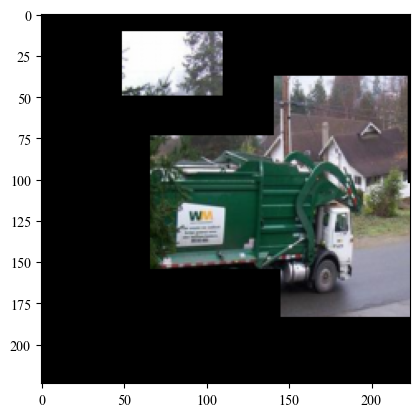

In [ ]:
plt.imshow(image.permute(1,2,0))

In [ ]:
z = apply_mask(image, mask)

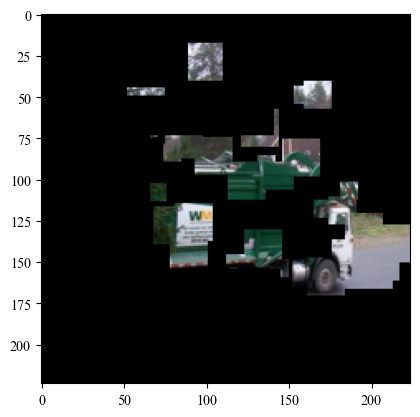

In [ ]:
plt.imshow(z.permute(1,2,0))

In [ ]:
predict_label(z.float())

6

In [ ]:
predict_label(x[10])

6

In [ ]:
z_mask = SCORE_MASK.copy()

In [ ]:
z_mask = np.multiply(z_mask, mask)

In [ ]:
# z_mask = np.ones_like(z_mask) - (z_mask - z_mask.min())/(z_mask.max() - z_mask.min())
z_mask = ((z_mask - z_mask.min())/(z_mask.max() - z_mask.min()))

In [ ]:
zdash_mask = torch.stack([torch.tensor(z_mask),torch.tensor(zero_mask),torch.tensor(zero_mask)])

In [ ]:
zx =torch.stack([torch.tensor(zero_mask),  torch.tensor(zero_mask), torch.tensor(image[0])])
zx = (zx - zx.min())/(zx.max() - zx.min())

<ipython-input-142-1d2ed24a647f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zx =torch.stack([torch.tensor(zero_mask),  torch.tensor(zero_mask), torch.tensor(image[0])])


In [ ]:
smooth_mask = torchvision.transforms.GaussianBlur(7, sigma=(2,3.4))(zdash_mask)
smooth_mask = torchvision.transforms.functional.adjust_saturation(smooth_mask, 1.5)
vis_r = torchvision.transforms.functional.adjust_saturation(x[0], 0).mul(torch.tensor(z_mask)+0.4)+zdash_mask
vis_s = torchvision.transforms.functional.adjust_contrast((torchvision.transforms.functional.adjust_saturation(x[10], 0)),0.5)*0.7+smooth_mask*1.1

In [ ]:
from matplotlib import font_manager
font_path = '/content/data/times new roman.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

Text(0.5, 1.0, 'Masked Prediction : garbage truck\n(Gross) ')

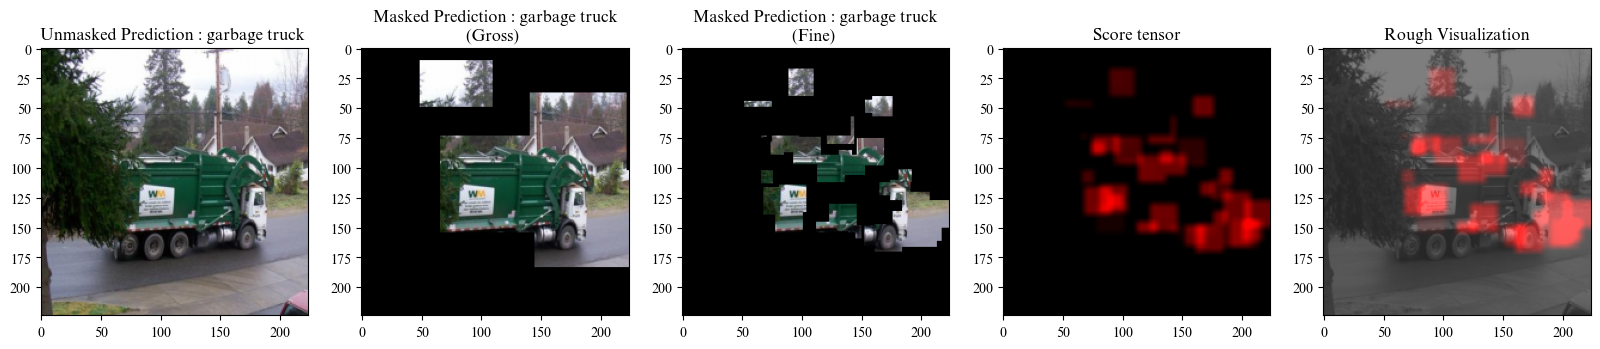

In [ ]:

fig, ax = plt.subplots(1,5, figsize = (20,10))
ax[0].imshow(x[10].permute(1,2,0))
ax[0].set_title(f"Unmasked Prediction : {data.classes[predict_label(x[10])][0]} ")
ax[2].imshow(z.permute(1,2,0))
ax[2].set_title(f"Masked Prediction : {data.classes[predict_label(z.float())][0]}\n(Fine) ")
ax[3].imshow(smooth_mask.permute(1,2,0))
ax[3].set_title(f"Score tensor")
ax[4].imshow(vis_s.permute(1,2,0))
ax[4].set_title(f"Rough Visualization")
ax[1].imshow(image.permute(1,2,0))
ax[1].set_title(f"Masked Prediction : {data.classes[predict_label(image.float())][0]}\n(Gross) ")

In [ ]:
data.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]